<a href="https://colab.research.google.com/github/jppascale/notebooks/blob/main/Chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
import pandas as pd
import requests as rq
import seaborn as sns

id_club = 'platense'
id_club_url = 'https://api.chess.com/pub/club/' + id_club

sns.set_theme(palette=['#5a3717','#5f4024','#634931','#68523e','#6d5b4b','#716458','#766d65','#7b7672', '#7C7774', '#7C7875'])


# Referencia APIs
---
**Doc: https://www.chess.com/news/view/published-data-api**

Información del club: https://api.chess.com/pub/club/platense

Partidas: https://api.chess.com/pub/club/platense/matches claves: "finished", "in_progress" y "registered"

Match: https://api.chess.com/pub/match/1436501



---



---



#Estadísticas generales del equipo


---



In [2]:
#@title
def calcular_puntos(row):
    #Calcula los puntos de los tableros de cada partida
    puntos = timeouts = 0
    for tablero in ['played_as_black', 'played_as_white']:
      if row[tablero] == 'win':
        puntos += 1
      elif row[tablero] in ('agreed', 'repetition', 'timevsinsufficient'):
        puntos += 0.5
      elif row[tablero] == 'timeout':
        timeouts += 1

    row.cant_partidas = 1 # se cuentan las participaciones en partidas del equipo (1 partida = 2 tableros)
    row.timeouts = timeouts
    row.puntos = puntos

    return row

rq_matches = rq.get(f"https://api.chess.com/pub/club/{id_club}/matches")
if rq_matches.ok:
  df = pd.DataFrame(rq_matches.json()["finished"])
  total_partidas = df.result.count()
  #print(df.result.value_counts())
  ganadas = df[df.result=='win'].result.count()
  perdidas = df[df.result=='lose'].result.count()
  tablas = df[df.result=='draw'].result.count()

  #Se recorren las partidas para sumar la cantidad de puntos a favor y puntos en contra. Además se contabiliza los puntos obtenidos por jugador
  matchs = df.rename(columns={'@id': 'id'}).id
  puntos_ganados = puntos_perdidos = 0
  jugadores = pd.DataFrame() #DF con los puntos de jugadores de todas las partidas
  for i, match_url in matchs.items():
    rq_match = rq.get(match_url)
    if rq_match.ok:
      match = rq_match.json()
      #el nro de team varía según quien inició el desafío.
      if match['teams']['team1']['@id'] == id_club_url:
        team_platense = 'team1'
        team_rival = 'team2'
      else:
        team_platense = 'team1'
        team_rival = 'team2'

      puntos_ganados += match['teams'][team_platense]['score']
      puntos_perdidos += match['teams'][team_rival]['score']

      partida = pd.DataFrame(match['teams'][team_platense]['players'])

      partida['puntos'] = partida['cant_partidas'] = partida['timeouts'] = 0 #se agregan datos al DF para sumarizar
      partida = partida.apply(calcular_puntos, axis='columns')
      jugadores = pd.concat([jugadores, partida], ignore_index=True)

    else:
      print("Error al procesar la partida")


  print('Partidas: ', total_partidas)
  print('Ganadas: {0} ({1}%)'.format(ganadas, round(ganadas/total_partidas*100,2)) )
  print('Perdidas: {0} ({1}%)'.format(perdidas, round(perdidas/total_partidas*100,2)) )
  print('Tablas: {0} ({1}%)'.format(tablas, round(tablas/total_partidas*100,2)) )
  print(f'Puntos a Favor: {puntos_ganados} - Puntos en contra: {puntos_perdidos}')

else:
  print("ERROR!!!")



Partidas:  125
Ganadas: 96 (76.8%)
Perdidas: 23 (18.4%)
Tablas: 6 (4.8%)
Puntos a Favor: 1724.0 - Puntos en contra: 1323.0


# Jugadores con más participaciones

,cant_partidas,timeouts
username,,
juamp14,62,0
sanagustin79,45,0
federfredericksen,36,16
miguelmessi,35,0
elmorejames,33,0
valenmartucci,30,0
daniddr,29,1
adrianjudasp,26,0
morichi_chess,23,0


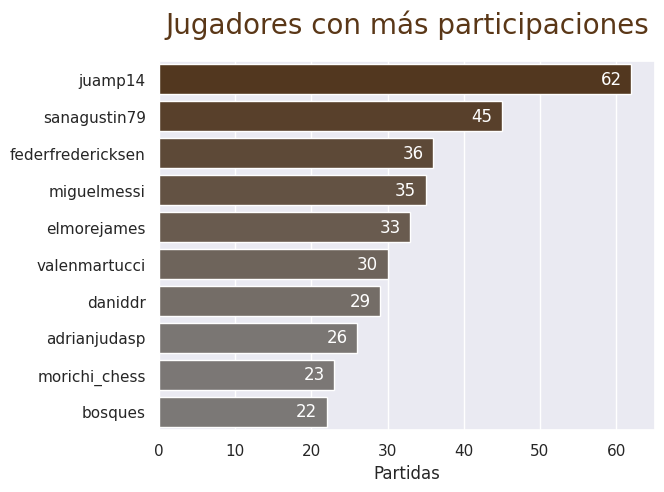

In [24]:
#@title
sum_jugadores = jugadores.groupby('username')[['puntos', 'cant_partidas', 'timeouts']].sum()
top10 = sum_jugadores.sort_values(['cant_partidas'], ascending=False)[['cant_partidas', 'timeouts']].iloc[:10]

grid = sns.barplot(data=top10, x='cant_partidas', y=top10.index, palette=sns.color_palette())
grid.set_title("Jugadores con más participaciones", fontdict={'fontsize': 20, 'color':sns.color_palette()[0]}, pad=20, ha='center')
grid.set_ylabel("")
grid.set_xlabel("Partidas")

for i in grid.patches:
  t = str(int(i.get_width()))
  x = i.get_x()+(i.get_width() - len(t)*2)
  y = i.get_y() + i.get_height()/2
  grid.annotate(text=t, xy=(x, y), color='white', va='center')

top10


# Jugadores que sumaron más puntos

,puntos,timeouts
username,,
juamp14,80.5,0
sanagustin79,54.0,0
elmorejames,45.5,0
miguelmessi,42.0,0
valenmartucci,42.0,0
federfredericksen,38.0,16
donrodrigoddc,35.5,0
morichi_chess,35.5,0
daniddr,32.0,1


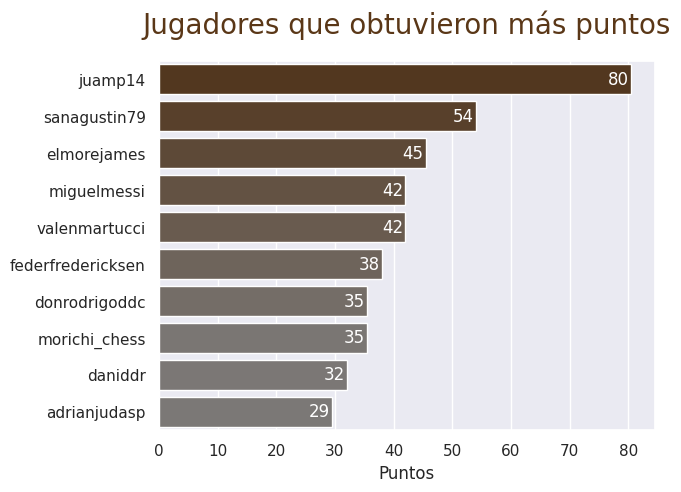

In [26]:
#@title
#sum_jugadores = jugadores.groupby('username')[['puntos', 'cant_partidas', 'timeouts']].sum()
top10 = sum_jugadores.sort_values(['puntos'], ascending=False)[['puntos', 'timeouts']].iloc[:10]

grid = sns.barplot(data=top10, x='puntos', y=top10.index, palette=sns.color_palette())
grid.set_title("Jugadores que obtuvieron más puntos", fontdict={'fontsize': 20, 'color':sns.color_palette()[0]}, pad=20, ha='center')
grid.set_ylabel("")
grid.set_xlabel("Puntos")

for i in grid.patches:
  t = str(int(i.get_width()))
  x = i.get_x()+(i.get_width() - len(t)*2)
  y = i.get_y() + i.get_height()/2
  grid.annotate(text=t, xy=(x, y), color='white', va='center')

top10


# Jugadores con más cantidad de Timeouts.

,timeouts
username,
federfredericksen,16
patone2,13
lautaroeliseomoreno,6
jebusdatolo,6
lautarxsxtx,5
alanger,4
siniestro72,4
diegocioccatto,4
ecdg,4


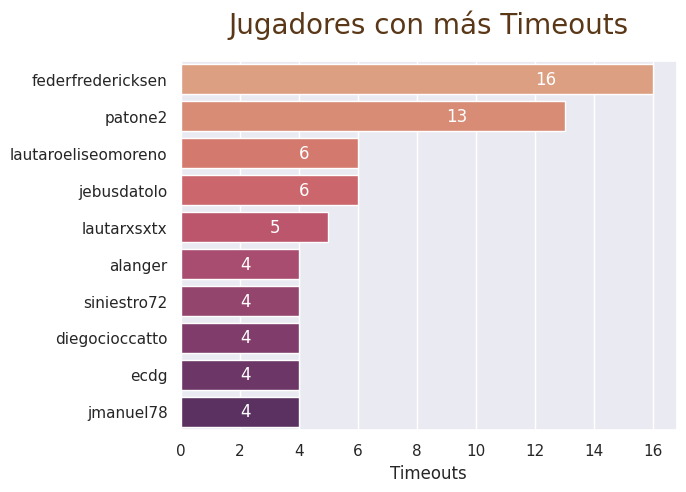

In [29]:
#@title
#sum_jugadores = jugadores.groupby('username')[['puntos', 'cant_partidas', 'timeouts']].sum()
top10 = sum_jugadores.sort_values(['timeouts'], ascending=False)[['timeouts']].iloc[:10]

grid = sns.barplot(data=top10, x='timeouts', y=top10.index, palette="flare")
grid.set_title("Jugadores con más Timeouts", fontdict={'fontsize': 20, 'color':sns.color_palette()[0]}, pad=20, ha='center')
grid.set_ylabel("")
grid.set_xlabel("Timeouts")

for i in grid.patches:
  t = str(int(i.get_width()))
  x = i.get_x()+(i.get_width() - len(t)*2)
  y = i.get_y() + i.get_height()/2
  grid.annotate(text=t, xy=(x, y), color='white', va='center')

top10
